# Example Experiment
> Experiment using Repeated MNIST and BatchBALD vs BALD vs random sampling

This notebook ties everything together and runs an AL loop.

In [1]:
# experiment

import blackhc.project.script
from tqdm.auto import tqdm

Neither src found as subdirectory in %s nor was a notebooks directory found!
%load_ext autoreload
%autoreload 2


In [2]:
import time
import numpy as np
import random

In [3]:
# experiment

import math

import torch
from torch import nn as nn
from torch.nn import functional as F

from batchbald_redux import (
    active_learning,
    batchbald,
    consistent_mc_dropout,
    joint_entropy,
    repeated_mnist,
    emnist,
)

Let's define our Bayesian CNN model that we will use to train MNIST.

In [4]:
# experiment


# class BayesianCNN(consistent_mc_dropout.BayesianModule):
#     def __init__(self, num_classes=10):
#         super().__init__()

#         self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
#         self.conv1_drop = consistent_mc_dropout.ConsistentMCDropout2d()
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
#         self.conv2_drop = consistent_mc_dropout.ConsistentMCDropout2d()
#         self.fc1 = nn.Linear(1024, 128)
#         self.fc1_drop = consistent_mc_dropout.ConsistentMCDropout()
#         self.fc2 = nn.Linear(128, num_classes)

#     def mc_forward_impl(self, input: torch.Tensor):
#         input = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(input)), 2))
#         input = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(input)), 2))
#         input = input.view(-1, 1024)
#         input = F.relu(self.fc1_drop(self.fc1(input)))
#         input = self.fc2(input)
#         input = F.log_softmax(input, dim=1)

#         return input

In [5]:
# net for EMNIST

class BayesianCNN(consistent_mc_dropout.BayesianModule):
    def __init__(self, num_classes=47):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv1_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv3_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc1_drop = consistent_mc_dropout.ConsistentMCDropout()
        self.fc2 = nn.Linear(512, num_classes)

    def mc_forward_impl(self, input:  torch.Tensor):
        input = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(input)), 2))
        input = F.relu(self.conv2_drop(self.conv2(input)))
        input = F.relu(F.max_pool2d(self.conv3_drop(self.conv3(input)), 2))
        input = input.view(-1, 128 * 4 * 4)
        input = F.relu(self.fc1_drop(self.fc1(input)))
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)
        return input

In [6]:
# net for CIFAR10

# model = nn.Sequential( # (batch_size, 3, 32, 32)
#         nn.Conv2d(3, 32, kernel_size=3), # (batch_size, 32, 30, 30)
#         nn.ReLU(inplace=True),
#         nn.Dropout(p=0.25),
#         nn.Conv2d(32, 32, kernel_size=3), # (batch_size, 32, 28, 28)
#         nn.ReLU(inplace=True),
#         nn.Dropout(p=0.25),
#         nn.MaxPool2d(kernel_size=2), # (batch_size, 64, 14, 14)
#         nn.Conv2d(32, 64, kernel_size=3), # (batch_size, 64, 12, 12)
#         nn.ReLU(inplace=True),
#         nn.Dropout(p=0.25),
#         nn.Conv2d(64, 64, kernel_size=3), # (batch_size, 64, 10, 10)
#         nn.ReLU(inplace=True),
#         nn.Dropout(p=0.25),
#         nn.MaxPool2d(kernel_size=2), # (batch_size, 64, 5, 5)
#         nn.Flatten(), # (batch_size, 64*5*5)
#         nn.Dropout(p=0.5),
#         nn.Linear(64*5*5, 10), # (batch_size, )
#         )

Grab our dataset, we'll use Repeated-MNIST. We will acquire to samples for each class for our initial training set.

In [7]:
# experiment

# train_dataset, test_dataset = repeated_mnist.create_repeated_MNIST_dataset(num_repetitions=4, add_noise=False)
# train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()
train_dataset, test_dataset = emnist.create_EMNIST_dataset()

num_initial_samples = 20
# num_classes = 10
# num_initial_samples = 0 # emnist
num_classes = 47 # emnist
# works fine with repeated_mnist.get_targets but be careful
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

For this example, we are going to take two shortcuts that will reduce the performance:
* we discard most of the training set and only keep 20k samples; and
* we don't implement early stopping or epoch-wise training.

Instead, we always train by drawing 24576 many samples from the training set. This will overfit in the beginning and underfit later, but it still is sufficient to achieve 90% accuracy with 105 samples in the training set. 

In [8]:
# experiment

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

max_training_samples = 150
acquisition_batch_size = 5 # initially: 5
num_inference_samples = 100
num_test_inference_samples = 5
num_samples = 100000

test_batch_size = 512
batch_size = 64
scoring_batch_size = 128
training_iterations = 4096 * 6

use_cuda = torch.cuda.is_available()

print(f"use_cuda: {use_cuda}")

device = "cuda:1" if use_cuda else "cpu"

kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(40000)

train_loader = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

# Run experiment
test_accs = []
test_loss = []
added_indices = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")

while True:
    model = BayesianCNN(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = model(data, 1).squeeze(1)
        loss = F.nll_loss(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = torch.logsumexp(model(data, num_test_inference_samples), dim=1) - math.log(
                num_test_inference_samples
            )
            loss += F.nll_loss(prediction, target, reduction="sum")

            prediction = prediction.max(1)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire pool predictions
    N = len(active_learning_data.pool_dataset)
    logits_N_K_C = torch.empty((N, num_inference_samples, num_classes), dtype=torch.double, pin_memory=use_cuda)

    with torch.no_grad():
        model.eval()

        for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
            data = data.to(device=device)

            lower = i * pool_loader.batch_size
            upper = min(lower + pool_loader.batch_size, N)
            logits_N_K_C[lower:upper].copy_(model(data, num_inference_samples).double(), non_blocking=True)
            
    with torch.no_grad():
        start = time.time()
        candidate_batch = batchbald.get_batchbald_batch(
            logits_N_K_C, acquisition_batch_size, num_samples, dtype=torch.double, device=device
        )
#         candidate_batch = batchbald.get_lbb_batch(
#             logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
#         )
#         candidate_batch = batchbald.get_bald_batch(
#             logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
#         )
#         candidate_batch = batchbald.get_random_batch(
#             logits_N_K_C, acquisition_batch_size, dtype=torch.double, device=device
#         )
        end = time.time()
        print("acquisition time (sec.):", end - start)
    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    pbar.update(len(dataset_indices))

use_cuda: True


Training Set Size:  13%|#3        | 20/150 [00:00<?, ?it/s]

Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 34.3680, Accuracy: 2226/18800 (11.84%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72780 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72780 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72780 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72780 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72780 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72780 [00:00<?, ?it/s]

acquisition time (sec.): 914.5568854808807
Dataset indices:  [104833  42420  30780 108288  32283]
Scores:  [1.6970827738035754, 3.0114380065866158, 3.8136826134065434, 4.244145874920983, 4.435426034785476]
Labels:  tensor([17, 36, 24, 26,  6])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 26.6117, Accuracy: 2471/18800 (13.14%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72775 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72775 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72775 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72775 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72775 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72775 [00:00<?, ?it/s]

acquisition time (sec.): 915.526020526886
Dataset indices:  [ 7174 58088 22297  6221 39213]
Scores:  [1.5694890442778977, 2.835430237698716, 3.7154507192769404, 4.179708025203618, 4.418856555997514]
Labels:  tensor([34, 35, 10, 13, 20])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 25.8533, Accuracy: 2752/18800 (14.64%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72770 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72770 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72770 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72770 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72770 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72770 [00:00<?, ?it/s]

acquisition time (sec.): 914.2896139621735
Dataset indices:  [43060 30039 75845 99856 83897]
Scores:  [1.6818900389014342, 3.0301860402317007, 3.881300433048551, 4.306088098061858, 4.479473904594051]
Labels:  tensor([44, 30, 20, 15,  3])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 24.5205, Accuracy: 3012/18800 (16.02%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72765 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72765 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72765 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72765 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72765 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72765 [00:00<?, ?it/s]

acquisition time (sec.): 913.8847332000732
Dataset indices:  [ 78858  58376 105906  19505   2109]
Scores:  [1.6696832853405719, 2.9968348834038263, 3.8696077024634308, 4.300860058747142, 4.486293615206063]
Labels:  tensor([26, 35, 38, 27, 45])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 20.7315, Accuracy: 3233/18800 (17.20%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72760 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72760 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72760 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72760 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72760 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72760 [00:00<?, ?it/s]

acquisition time (sec.): 913.6681380271912
Dataset indices:  [71030 14857 18708 74911 38430]
Scores:  [1.5950619673748299, 2.973234027962379, 3.837635401748287, 4.28821868844772, 4.466662157184606]
Labels:  tensor([25,  4, 16,  7, 46])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 17.9721, Accuracy: 3589/18800 (19.09%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72755 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72755 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72755 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72755 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72755 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72755 [00:00<?, ?it/s]

acquisition time (sec.): 914.6096894741058
Dataset indices:  [ 55318  45428  86511 107573  67632]
Scores:  [1.7434160952403674, 3.1248037037771774, 3.9600932624751097, 4.351422356296285, 4.515414240747825]
Labels:  tensor([23, 44,  6,  4, 41])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 18.3873, Accuracy: 3603/18800 (19.16%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72750 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72750 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72750 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72750 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72750 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72750 [00:00<?, ?it/s]

acquisition time (sec.): 915.4438588619232
Dataset indices:  [ 23139  54457 100226 109696  55374]
Scores:  [1.7158182009643017, 3.081921579249363, 3.917655602700118, 4.323102834748967, 4.487168169891935]
Labels:  tensor([33, 16, 26, 20, 34])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 17.1536, Accuracy: 3577/18800 (19.03%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72745 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72745 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72745 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72745 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72745 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72745 [00:00<?, ?it/s]

acquisition time (sec.): 914.6856782436371
Dataset indices:  [59074 14416 74295 34623 52365]
Scores:  [1.6475302092545967, 3.08939575213518, 3.9376730129538426, 4.3262770096381775, 4.489464773897927]
Labels:  tensor([ 9, 25, 19, 16,  0])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 17.4446, Accuracy: 3723/18800 (19.80%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72740 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72740 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72740 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72740 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72740 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72740 [00:00<?, ?it/s]

acquisition time (sec.): 911.2254831790924
Dataset indices:  [109234 102810   4171   3907  18517]
Scores:  [1.846662748786661, 3.2927444550437324, 4.088286112656743, 4.42342353139953, 4.544663333541074]
Labels:  tensor([42, 11, 35, 30, 17])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 14.8008, Accuracy: 4002/18800 (21.29%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72735 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72735 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72735 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72735 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72735 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72735 [00:00<?, ?it/s]

acquisition time (sec.): 912.2357134819031
Dataset indices:  [112309  63736  38636  31863  84216]
Scores:  [1.706209806020483, 3.0884969715006196, 3.9518235014648146, 4.3509796489086625, 4.507710541591048]
Labels:  tensor([14, 30, 25, 18,  4])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 14.1190, Accuracy: 3889/18800 (20.69%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72730 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72730 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72730 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72730 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72730 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72730 [00:00<?, ?it/s]

acquisition time (sec.): 912.1686110496521
Dataset indices:  [ 43250 100064 106523  82766  30481]
Scores:  [1.731460421455747, 3.142626430429577, 4.008946512647889, 4.391840056555806, 4.528321133693813]
Labels:  tensor([45,  3,  2, 32, 13])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 15.2218, Accuracy: 4479/18800 (23.82%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72725 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72725 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72725 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72725 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72725 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72725 [00:00<?, ?it/s]

acquisition time (sec.): 912.2849323749542
Dataset indices:  [ 93994 112448  52872  43253  39456]
Scores:  [1.8534459540647266, 3.3286351352479033, 4.108680734856586, 4.442529990542148, 4.5472670321845765]
Labels:  tensor([39, 42,  5,  2, 11])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 12.0137, Accuracy: 4139/18800 (22.02%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72720 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72720 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72720 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72720 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72720 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72720 [00:00<?, ?it/s]

acquisition time (sec.): 911.9755301475525
Dataset indices:  [94393 86422 49818 30912 78878]
Scores:  [1.6602654067442684, 3.0311369849698266, 3.891836684466109, 4.310970759000934, 4.4878998395432985]
Labels:  tensor([35, 35,  4,  4, 35])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 12.0021, Accuracy: 4434/18800 (23.59%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72715 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72715 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72715 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72715 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72715 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72715 [00:00<?, ?it/s]

acquisition time (sec.): 913.8719346523285
Dataset indices:  [69772 13773 93216 34472 94699]
Scores:  [1.7457725324791107, 3.2104069280404004, 4.072111127690086, 4.405573575575321, 4.521869078428839]
Labels:  tensor([33, 11, 24, 11, 44])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 12.7718, Accuracy: 4432/18800 (23.57%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72710 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72710 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72710 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72710 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72710 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72710 [00:00<?, ?it/s]

acquisition time (sec.): 913.512467622757
Dataset indices:  [110296  65918  63023   1767  63066]
Scores:  [1.7857678087834192, 3.1613306909545176, 4.00618946182192, 4.3784330877712545, 4.525816281809082]
Labels:  tensor([36,  3, 13, 36,  4])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 11.4710, Accuracy: 4794/18800 (25.50%)


Evaluating Acquisition Set:   0%|          | 0/569 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72705 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72705 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72705 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72705 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72705 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72705 [00:00<?, ?it/s]

acquisition time (sec.): 914.6824128627777
Dataset indices:  [ 12513  88819  13403 107228  17211]
Scores:  [1.6651387596651137, 3.065493803097416, 3.964478660510871, 4.35090790014801, 4.51073028397515]
Labels:  tensor([23, 37,  2, 13, 22])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 10.9615, Accuracy: 4793/18800 (25.49%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72700 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72700 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72700 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72700 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72700 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72700 [00:00<?, ?it/s]

acquisition time (sec.): 913.5619552135468
Dataset indices:  [81485 79513 22236 54292 95462]
Scores:  [1.8190387348632262, 3.2759329528704524, 4.085152098294431, 4.420762766641534, 4.54271640616364]
Labels:  tensor([ 5, 39, 14,  3, 27])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 10.4106, Accuracy: 5112/18800 (27.19%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72695 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72695 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72695 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72695 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72695 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72695 [00:00<?, ?it/s]

acquisition time (sec.): 914.1177380084991
Dataset indices:  [ 50009 104198  95561  48834  89304]
Scores:  [1.7964360546249258, 3.2502366770345574, 4.082824880902791, 4.430740320845496, 4.544819021588543]
Labels:  tensor([40, 43, 36, 37, 46])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 9.4493, Accuracy: 4956/18800 (26.36%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72690 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72690 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72690 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72690 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72690 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72690 [00:00<?, ?it/s]

acquisition time (sec.): 914.3466219902039
Dataset indices:  [25672 69399 16700 99194 19348]
Scores:  [1.7848495229141297, 3.2030146972851674, 4.031997623523413, 4.397100703560449, 4.532864067678071]
Labels:  tensor([ 6, 46,  3,  0, 17])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 9.1116, Accuracy: 5146/18800 (27.37%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72685 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72685 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72685 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72685 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72685 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72685 [00:00<?, ?it/s]

acquisition time (sec.): 914.8611090183258
Dataset indices:  [96308 19220  3513 54282 16839]
Scores:  [1.7677234908628643, 3.1781481500805278, 4.020509406130875, 4.383256196288416, 4.523718638944579]
Labels:  tensor([ 5, 24, 19,  2, 11])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 8.2497, Accuracy: 5620/18800 (29.89%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72680 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72680 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72680 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72680 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72680 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72680 [00:00<?, ?it/s]

acquisition time (sec.): 914.4582598209381
Dataset indices:  [110484  88459  49380  89403  69804]
Scores:  [1.7047918026340538, 3.083355640108658, 3.931178411337651, 4.352194821318225, 4.507960965411407]
Labels:  tensor([34, 25, 30, 36, 19])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 8.2847, Accuracy: 5586/18800 (29.71%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72675 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72675 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72675 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72675 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72675 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72675 [00:00<?, ?it/s]

acquisition time (sec.): 915.1457657814026
Dataset indices:  [17569 45022  9724 18871 21712]
Scores:  [1.7658106970782554, 3.1672668870286316, 3.9994989244218635, 4.374144375833307, 4.520055890886429]
Labels:  tensor([44, 12, 46, 46, 21])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 8.2223, Accuracy: 5545/18800 (29.49%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72670 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72670 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72670 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72670 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72670 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72670 [00:00<?, ?it/s]

acquisition time (sec.): 914.9900662899017
Dataset indices:  [ 48057  93163  17206  43877 108055]
Scores:  [1.7381235617891018, 3.109727640370858, 3.954728126828644, 4.342452094403164, 4.5015924390794595]
Labels:  tensor([43, 46, 29, 35, 30])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 7.1168, Accuracy: 5840/18800 (31.06%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72665 [00:05<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72665 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72665 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72665 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72665 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72665 [00:00<?, ?it/s]

acquisition time (sec.): 914.1554837226868
Dataset indices:  [104281  68318  76406  64353  25319]
Scores:  [1.6215986982966322, 3.000711043545496, 3.8823867544153443, 4.313730115132183, 4.498005085019545]
Labels:  tensor([31,  9, 17,  1, 24])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 6.9843, Accuracy: 5728/18800 (30.47%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72660 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72660 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72660 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72660 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72660 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72660 [00:00<?, ?it/s]

acquisition time (sec.): 914.256532907486
Dataset indices:  [ 29980  48707 107958  44492  59486]
Scores:  [1.783439670018545, 3.194466765701514, 4.014267612174638, 4.395667914358945, 4.531091369477691]
Labels:  tensor([20, 34, 17, 30, 39])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 6.1301, Accuracy: 6337/18800 (33.71%)


Evaluating Acquisition Set:   0%|          | 0/568 [00:00<?, ?it/s]

Conditional Entropy:   0%|          | 0/72655 [00:00<?, ?it/s]

BatchBALD:   0%|          | 0/5 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72655 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72655 [00:00<?, ?it/s]

ExactJointEntropy.compute_batch:   0%|          | 0/72655 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72655 [00:00<?, ?it/s]

SampledJointEntropy.compute_batch:   0%|          | 0/72655 [00:00<?, ?it/s]

acquisition time (sec.): 915.0282592773438
Dataset indices:  [64954 61351 13067 96518 72354]
Scores:  [1.7958306010563945, 3.2449145250830806, 4.034068961428285, 4.385441188802391, 4.524075442850455]
Labels:  tensor([10, 22, 19, 37, 20])


Training:   0%|          | 0/384 [00:00<?, ?it/s]

Testing:   0%|          | 0/37 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f33f332be50>
Traceback (most recent call last):
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/rubaha96/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/home/rubaha96/anaconda3/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Test set: Average loss: 6.8761, Accuracy: 6152/18800 (32.72%)


In [9]:
# hide
# experiment
test_accs

[11.840425531914894,
 13.143617021276595,
 14.638297872340425,
 16.02127659574468,
 17.1968085106383,
 19.090425531914892,
 19.164893617021278,
 19.02659574468085,
 19.8031914893617,
 21.28723404255319,
 20.68617021276596,
 23.824468085106382,
 22.01595744680851,
 23.585106382978722,
 23.574468085106382,
 25.5,
 25.49468085106383,
 27.19148936170213,
 26.361702127659573,
 27.372340425531913,
 29.893617021276597,
 29.71276595744681,
 29.49468085106383,
 31.06382978723404,
 30.46808510638298,
 33.70744680851064,
 32.723404255319146]

In [31]:
# emnist batch 5
lbb_emnist = [11.840425531914894,
 12.569148936170214,
 13.22340425531915,
 15.03191489361702,
 14.345744680851064,
 14.01063829787234,
 16.03723404255319,
 16.03723404255319,
 17.138297872340427,
 17.04787234042553,
 19.388297872340427,
 19.21276595744681,
 20.05851063829787,
 20.579787234042552,
 22.24468085106383,
 21.893617021276597,
 22.70212765957447,
 23.829787234042552,
 23.425531914893618,
 24.95744680851064,
 25.46808510638298,
 27.154255319148938,
 26.367021276595743,
 27.70212765957447,
 28.49468085106383,
 29.79787234042553,
 30.079787234042552]

bald_emnist = [11.840425531914894,
 12.5,
 13.787234042553191,
 14.611702127659575,
 13.46808510638298,
 13.46808510638298,
 14.71808510638298,
 16.74468085106383,
 20.398936170212767,
 19.377659574468087,
 21.595744680851062,
 20.404255319148938,
 22.372340425531913,
 24.00531914893617,
 23.79787234042553,
 24.54255319148936,
 24.69148936170213,
 24.925531914893618,
 25.72340425531915,
 26.22340425531915,
 27.24468085106383,
 27.46276595744681,
 27.904255319148938,
 28.585106382978722,
 28.079787234042552,
 29.585106382978722,
 29.590425531914892]

random_emnist = [11.840425531914894,
 12.856382978723405,
 15.122340425531915,
 17.0,
 17.72340425531915,
 17.925531914893618,
 21.21276595744681,
 21.590425531914892,
 22.19148936170213,
 24.71276595744681,
 24.877659574468087,
 24.06382978723404,
 24.73936170212766,
 26.180851063829788,
 28.02127659574468,
 29.606382978723403,
 30.80851063829787,
 29.73404255319149,
 30.75,
 29.856382978723403,
 31.3031914893617,
 30.904255319148938,
 32.67553191489362,
 33.40425531914894,
 33.930851063829785,
 34.351063829787236,
 36.09574468085106]

bb_emnist = [11.840425531914894,
 13.143617021276595,
 14.638297872340425,
 16.02127659574468,
 17.1968085106383,
 19.090425531914892,
 19.164893617021278,
 19.02659574468085,
 19.8031914893617,
 21.28723404255319,
 20.68617021276596,
 23.824468085106382,
 22.01595744680851,
 23.585106382978722,
 23.574468085106382,
 25.5,
 25.49468085106383,
 27.19148936170213,
 26.361702127659573,
 27.372340425531913,
 29.893617021276597,
 29.71276595744681,
 29.49468085106383,
 31.06382978723404,
 30.46808510638298,
 33.70744680851064,
 32.723404255319146]

In [11]:
# batch 20, reps=4
# [56.23, 61.58, 68.37, 71.21, 75.78, 83.07, 84.06, 84.09]

In [12]:
lbb15 = [66.63,
 63.12,
 66.98,
 70.25,
 68.34,
 67.08,
 76.16,
 81.12,
 80.93,
 82.49,
 85.7,
 86.22,
 86.54,
 84.93,
 85.88,
 87.64,
 88.2,
 88.84,
 89.49,
 90.07,
 89.59,
 89.19,
 90.44,
 91.04,
 90.91,
 91.5,
 91.97]

lbb110 = [66.63,
 65.28,
 71.23,
 72.55,
 76.22,
 78.34,
 85.8,
 85.98,
 85.72,
 87.42,
 87.96,
 89.21,
 90.82,
 90.24]

lbb45 = [56.23,
 61.56,
 64.93,
 65.2,
 70.6,
 74.1,
 75.65,
 78.22,
 81.65,
 83.91,
 85.51,
 85.92,
 86.02,
 84.85,
 88.06,
 89.22,
 87.42,
 88.13,
 89.0,
 90.02,
 87.64,
 89.52,
 90.37,
 89.79,
 91.21,
 91.55,
 90.32]

lbb410 = [56.23,
 64.97,
 65.78,
 77.12,
 75.46,
 78.52,
 82.45,
 80.91,
 87.24,
 86.85,
 88.21,
 89.24,
 89.49,
 89.19]

In [13]:
# 0 reps, start 100 end 150
# bald_accs = [85.06, 87.8, 88.4, 89.55, 88.17, 88.78, 89.26, 91.12, 91.11, 91.91, 92.31]

In [14]:
# hide
# experiment
test_loss

[tensor(34.3680, device='cuda:1'),
 tensor(26.6117, device='cuda:1'),
 tensor(25.8533, device='cuda:1'),
 tensor(24.5205, device='cuda:1'),
 tensor(20.7315, device='cuda:1'),
 tensor(17.9721, device='cuda:1'),
 tensor(18.3873, device='cuda:1'),
 tensor(17.1536, device='cuda:1'),
 tensor(17.4446, device='cuda:1'),
 tensor(14.8008, device='cuda:1'),
 tensor(14.1190, device='cuda:1'),
 tensor(15.2218, device='cuda:1'),
 tensor(12.0137, device='cuda:1'),
 tensor(12.0021, device='cuda:1'),
 tensor(12.7718, device='cuda:1'),
 tensor(11.4710, device='cuda:1'),
 tensor(10.9615, device='cuda:1'),
 tensor(10.4106, device='cuda:1'),
 tensor(9.4493, device='cuda:1'),
 tensor(9.1116, device='cuda:1'),
 tensor(8.2497, device='cuda:1'),
 tensor(8.2847, device='cuda:1'),
 tensor(8.2223, device='cuda:1'),
 tensor(7.1168, device='cuda:1'),
 tensor(6.9843, device='cuda:1'),
 tensor(6.1301, device='cuda:1'),
 tensor(6.8761, device='cuda:1')]

In [15]:
# hide
# experiment
added_indices

[array([104833,  42420,  30780, 108288,  32283]),
 array([ 7174, 58088, 22297,  6221, 39213]),
 array([43060, 30039, 75845, 99856, 83897]),
 array([ 78858,  58376, 105906,  19505,   2109]),
 array([71030, 14857, 18708, 74911, 38430]),
 array([ 55318,  45428,  86511, 107573,  67632]),
 array([ 23139,  54457, 100226, 109696,  55374]),
 array([59074, 14416, 74295, 34623, 52365]),
 array([109234, 102810,   4171,   3907,  18517]),
 array([112309,  63736,  38636,  31863,  84216]),
 array([ 43250, 100064, 106523,  82766,  30481]),
 array([ 93994, 112448,  52872,  43253,  39456]),
 array([94393, 86422, 49818, 30912, 78878]),
 array([69772, 13773, 93216, 34472, 94699]),
 array([110296,  65918,  63023,   1767,  63066]),
 array([ 12513,  88819,  13403, 107228,  17211]),
 array([81485, 79513, 22236, 54292, 95462]),
 array([ 50009, 104198,  95561,  48834,  89304]),
 array([25672, 69399, 16700, 99194, 19348]),
 array([96308, 19220,  3513, 54282, 16839]),
 array([110484,  88459,  49380,  89403,  6980

In [16]:
# 4 rep, batch 10
# lbb410 = [56.23,
#  67.49,
#  67.34,
#  66.76,
#  67.87,
#  68.64,
#  70.06,
#  73.02,
#  70.27,
#  74.29,
#  76.27,
#  78.28,
#  78.81,
#  79.13]

In [17]:
# 0 rep, batch 5
# 0 rep, batch 10
bald010 = [66.63,
 65.01,
 74.26,
 76.37,
 78.61,
 80.54,
 83.73,
 84.82,
 87.26,
 87.36,
 88.4,
 88.39,
 91.6,
 90.73]
bb010 = [66.63,
 71.19,
 70.62,
 78.59,
 79.32,
 78.93,
 82.71,
 86.91,
 84.98,
 88.03,
 89.43,
 89.1,
 91.49,
 92.11]
lbb010 = [66.63,
 68.06,
 73.81,
 78.45,
 78.86,
 77.3,
 82.43,
 83.06,
 84.13,
 85.62,
 87.15,
 87.59,
 88.06,
 88.78]

In [18]:
# random
# 0 rep, batch 5
random05 = [63.51,
 63.1,
 65.0,
 67.0,
 73.39,
 76.98,
 73.58,
 78.76,
 77.33,
 78.42,
 78.12,
 82.04,
 81.41,
 80.79,
 83.71,
 84.47,
 86.04,
 86.2,
 86.03,
 86.56,
 85.67,
 87.84,
 89.0,
 87.5,
 88.02,
 87.61,
 89.07]
# 0 rep, batch 10
random010 = [63.51,
 68.66,
 79.08,
 79.04,
 78.91,
 83.52,
 83.5,
 83.02,
 85.66,
 84.58,
 86.81,
 87.1,
 87.79,
 88.46]
# 1 rep, batch 5
random15 = [63.51,
 63.1,
 65.0,
 67.0,
 73.39,
 76.98,
 73.58,
 78.76,
 77.33,
 78.42,
 78.12,
 82.04,
 81.41,
 80.79,
 83.71,
 84.47,
 86.04,
 86.2,
 86.03,
 86.56,
 85.67,
 87.84,
 89.0,
 87.5,
 88.02,
 87.61,
 89.07]
# 1 rep, batch 10
random110 = [63.51,
 68.66,
 79.08,
 79.04,
 78.91,
 83.52,
 83.5,
 83.02,
 85.66,
 84.58,
 86.81,
 87.1,
 87.79,
 88.46]
# 4 rep, batch 5
random45 = [56.02,
 59.41,
 60.08,
 62.14,
 65.11,
 71.61,
 74.46,
 78.1,
 78.48,
 79.59,
 83.55,
 80.61,
 83.15,
 81.93,
 83.54,
 85.45,
 84.05,
 85.68,
 87.09,
 87.41,
 87.03,
 86.7,
 86.69,
 87.43,
 89.16,
 88.77,
 87.45]
# 4 rep, batch 10
random410 = [56.02,
 65.99,
 74.79,
 80.14,
 77.86,
 81.39,
 78.78,
 81.83,
 83.64,
 85.94,
 86.16,
 85.0,
 85.97,
 85.06]

In [19]:
# RMNIST, number of rep-s = 1, batch 5
test_accs_bb = [
    64.75,
    68.19,
    69.0,
    65.95,
    73.85,
    73.78,
    76.59,
    79.4,
    78.45,
    79.99,
    83.43,
    88.24,
    89.86,
    87.31,
    88.02,
    88.99,
    89.43,
    90.39,
    89.94,
    88.93,
    89.93,
    92.08,
    91.15,
    91.77,
    89.94,
    91.11,
    91.43,
]

test_accs_lbb1 = [62.66,
     63.55,
     62.47,
     68.19,
     75.31,
     79.12,
     77.11,
     79.72,
     79.42,
     78.81,
     78.53,
     81.83,
     84.57,
     83.12,
     83.93,
     83.86,
     83.92,
     84.76,
     85.7,
     87.54,
     88.09,
     88.58,
     87.71,
     87.92,
     88.58,
     88.92,
     88.66,
]

test_accs_lbb2 = [61.76,
 60.51,
 66.17,
 68.88,
 71.93,
 74.63,
 73.54,
 73.16,
 72.43,
 79.26,
 81.64,
 79.49,
 78.77,
 81.88,
 82.63,
 82.56,
 82.28,
 82.81,
 82.98,
 82.66,
 82.25,
 82.92,
 82.11,
 82.28,
 84.43,
 83.63,
 84.72]
# last good
test_accs_lbb3 = [59.6,
 61.51,
 67.97,
 74.64,
 74.66,
 77.24,
 80.06,
 81.96,
 79.58,
 81.6,
 81.67,
 82.8,
 80.94,
 83.04,
 81.43,
 81.37,
 81.06,
 81.95,
 82.43,
 82.45,
 83.22,
 85.06,
 82.62,
 83.67,
 85.59,
 85.08,
 84.52]

test_accs_lbb31 = [65.51,
 66.9,
 62.88,
 68.79,
 69.23,
 72.01,
 76.17,
 77.67,
 77.74,
 76.64,
 77.19,
 78.37,
 77.02,
 78.06,
 79.7,
 78.45,
 82.79,
 81.24,
 81.52,
 83.8,
 82.9,
 85.27,
 85.21,
 85.44,
 85.95,
 85.2,
 86.66]

test_accs_lbb4_slow = [57.91,
 62.57,
 68.64,
 74.28,
 74.36,
 81.17,
 82.52,
 82.03,
 77.66,
 83.6,
 84.5,
 84.12,
 86.72,
 86.8,
 88.4,
 86.98,
 86.36,
 86.66,
 86.91,
 88.67,
 88.48,
 89.39,
 88.82,
 89.07,
 89.38,
 89.28,
 89.54]

test_accs_lbb4_slow = [57.91,
 62.57,
 68.64,
 74.28,
 74.36,
 81.17,
 82.52,
 82.03,
 77.66,
 83.6,
 84.5,
 84.12,
 86.72,
 86.8,
 88.4,
 86.98,
 86.36,
 86.66,
 86.91,
 88.67,
 88.48,
 89.39,
 88.82,
 89.07,
 89.38,
 89.28,
 89.54]
###
test_accs_lbb5_slow = [59.63,
 61.38,
 61.83,
 68.12,
 69.48,
 68.96,
 72.4,
 70.7,
 73.74,
 75.68,
 78.3,
 77.77,
 79.06,
 82.22,
 81.59,
 80.36,
 82.26,
 85.98,
 84.61,
 86.4,
 87.85,
 88.29,
 86.65,
 90.27,
 90.51,
 89.82,
 88.77]

test_accs_lbb52_slow = [57.1,
 59.44,
 65.32,
 67.16,
 73.31,
 76.28,
 76.8,
 76.51,
 78.22,
 80.85,
 81.82,
 80.77,
 83.16,
 82.29,
 83.95,
 84.41,
 87.33,
 87.52,
 87.49,
 86.11,
 88.03,
 88.74,
 88.99,
 87.6,
 90.18,
 88.12,
 90.17]
###
test_accs_bald=[62.69,
 69.11,
 75.98,
 73.79,
 75.67,
 78.65,
 80.06,
 80.23,
 80.64,
 80.9,
 82.24,
 84.49,
 84.55,
 84.96,
 86.21,
 86.58,
 87.85,
 89.3,
 89.53,
 89.35,
 89.81,
 90.03,
 89.88,
 90.96,
 92.14,
 93.21,
 92.11]

max_training_samples = 150
acquisition_batch_size = 5
num_inference_samples = 100
num_test_inference_samples = 5
num_samples = 100000
num_initial_samples = 20
num_classes = 10

In [20]:
# RMNIST, number of rep-s = 1, batch 10
test_accs_b10 = [66.16,
 67.6,
 69.82,
 72.47,
 71.86,
 79.88,
 81.46,
 81.17,
 85.12,
 86.05,
 85.55,
 88.5,
 86.69,
 89.43]
test_accs_bb10 = [64.18,
 70.83,
 77.95,
 80.2,
 82.41,
 79.55,
 83.35,
 84.99,
 89.56,
 89.52,
 89.49,
 90.2,
 91.06,
 91.4]
test_accs_lbb10 = [67.08,
 73.79,
 75.21,
 76.72,
 77.3,
 78.95,
 81.78,
 84.38,
 83.0,
 84.93,
 86.53,
 86.36,
 88.02,
 91.42]

In [21]:
# RMNIST, rep = 4, batch 5

test_accs4_b5 = [63.74,
 64.77,
 63.78,
 66.57,
 67.89,
 67.58,
 69.85,
 64.31,
 69.46,
 69.62,
 68.3,
 71.48,
 65.71,
 72.06,
 75.66,
 74.67,
 72.86,
 76.44,
 76.43,
 80.59,
 79.78,
 78.91,
 78.52,
 79.2,
 79.86,
 75.84,
 81.2] # 20 sec # can take [9, 9, 9, 9, 9]
# scores can be [1.3700689427997434, 1.3700689427997434, 1.3700689427997434, 1.3700689427997434, 1.3381412600750857]
# oft sit-n: 
# Scores:  [1.2813781095778696, 1.2813781095778696, 1.2813781095778696, 1.2813781095778696, 1.2697754527308138]
# Labels:  tensor([8, 8, 8, 8, 8])
test_accs4_bb5 = [64.63,
 66.61,
 68.86,
 75.15,
 78.7,
 79.84,
 81.43,
 82.02,
 85.72,
 83.67,
 88.4,
 88.01,
 89.21,
 89.42,
 88.98,
 89.07,
 90.84,
 90.55,
 90.44,
 91.9,
 91.04,
 91.65,
 91.4,
 92.03,
 92.74,
 92.48,
 92.72] # 70 sec
test_accs4_lbb5 = [65.37,
 66.87,
 69.01,
 66.13,
 71.85,
 72.77,
 68.97,
 70.64,
 71.03,
 68.81,
 78.61,
 79.61,
 78.8,
 80.68,
 78.74,
 78.32,
 76.68,
 78.68,
 79.06,
 81.54,
 81.0,
 81.9,
 80.92,
 81.9,
 80.89,
 82.04,
 84.24] # 540 sec

test_accs4_lbb51 = [59.91,
 63.08,
 67.98,
 68.95,
 67.69,
 70.64,
 69.58,
 70.67,
 67.65,
 68.38,
 71.14,
 72.57,
 74.21,
 74.93,
 76.02,
 74.3,
 75.55,
 74.96,
 78.79,
 80.96,
 77.79,
 74.76,
 80.41,
 79.55,
 80.95,
 82.77,
 81.96] # final

In [22]:
# RMNIST, rep 4, batch 10
test_accs4_b10 = [61.19,
 62.25,
 67.02,
 67.0,
 70.44,
 67.22,
 70.41,
 69.79,
 72.58,
 71.07,
 72.1,
 72.56,
 77.73,
 76.29] # 20 sec
test_accs4_bb10 = [68.48,
 74.95,
 75.58,
 81.8,
 86.25,
 87.83,
 87.75,
 89.64,
 89.44,
 89.72,
 89.97,
 89.7,
 90.59,
 89.82] # 3311.62 sec
test_accs4_lbb10 = []

In [23]:
# hide
# experiment
# !pip install matplotlib

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [25]:
# setting 3 imgs in a row
# plt.figure(figsize=(20, 15))
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.size'] = 85
# linewidth=7.0

In [26]:
# plt.figure(figsize=(20, 15))
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.size'] = 85

# plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), bald010, 'k', label='bald', linewidth=7.0)
# plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), bb010, 'g', label='bb', linewidth=7.0)
# plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), lbb110, 'b', label='lbb', linewidth=7.0)
# plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), random010, 'c', label='rand', linewidth=7.0)
# plt.xlabel("Number of training samples")
# plt.ylabel("Accuracy")
# plt.title("Accuracy, MNIST, batch 5")
# plt.hlines(90, 20, 150, linestyles="dashed", color="r")
# plt.legend()
# plt.savefig('fig1.svg')
# plt.show()

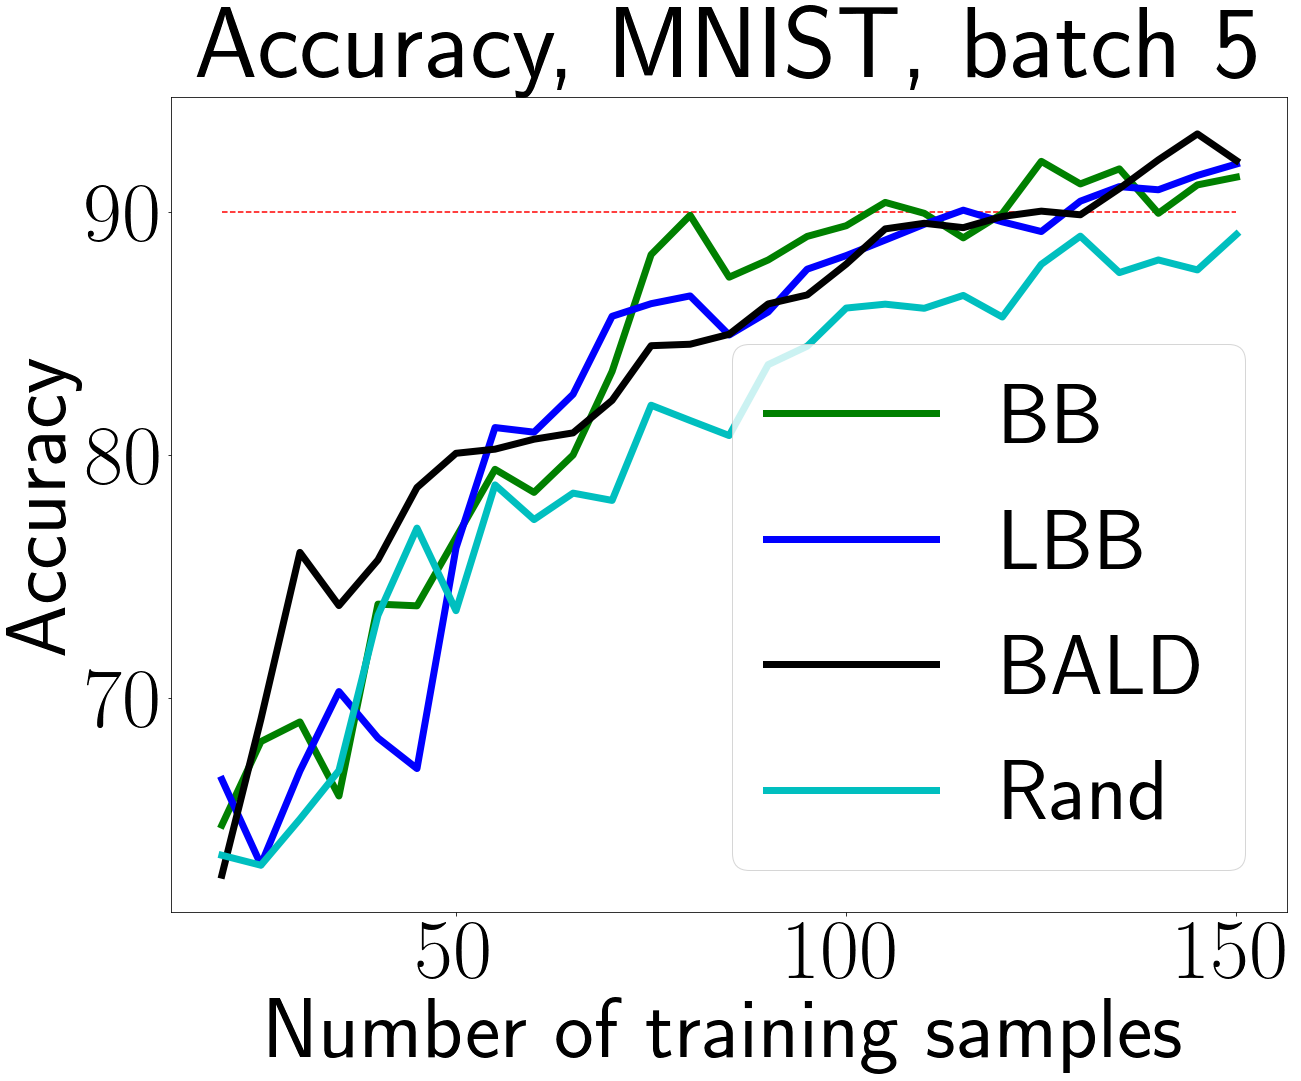

In [27]:
plt.figure(figsize=(20, 15))
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 85

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs_bb, 'g', label='BB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), lbb15, 'b', label='LBB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs_bald, 'k', label='BALD', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), random15, 'c', label='Rand', linewidth=7.0)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy, MNIST, batch 5")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.legend()
plt.savefig('mnist-batch5.svg')
plt.show()

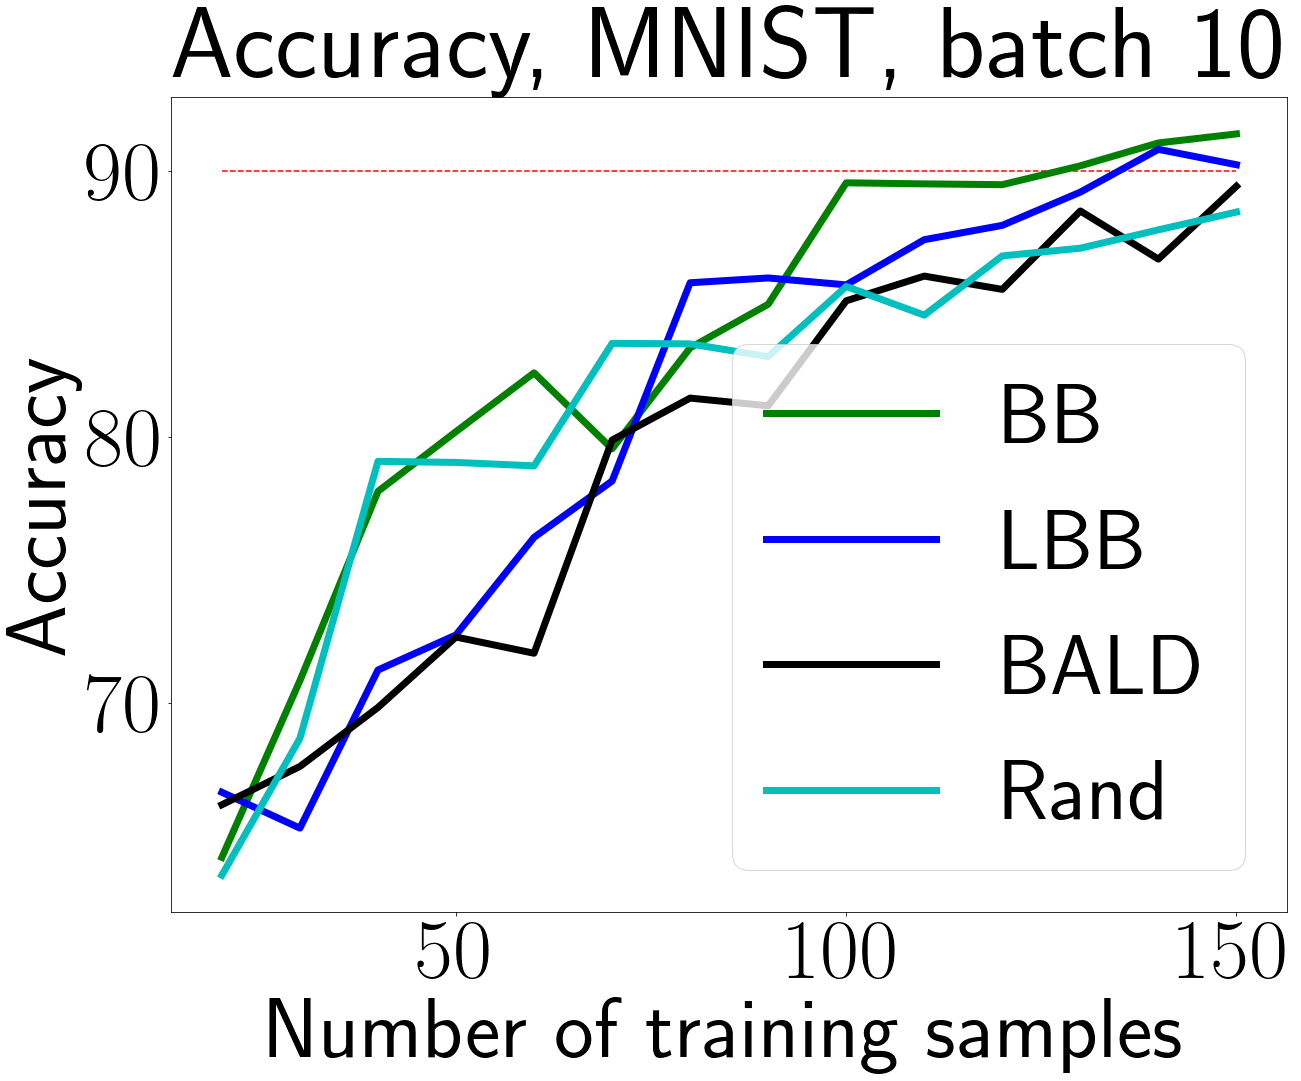

In [28]:
plt.figure(figsize=(20, 15))
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 85

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), test_accs_bb10, 'g', label='BB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), lbb110, 'b', label='LBB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), test_accs_b10, 'k', label='BALD', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), random110, 'c', label='Rand', linewidth=7.0)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy, MNIST, batch 10")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.legend()
plt.savefig('mnist-batch10.svg')
plt.show()

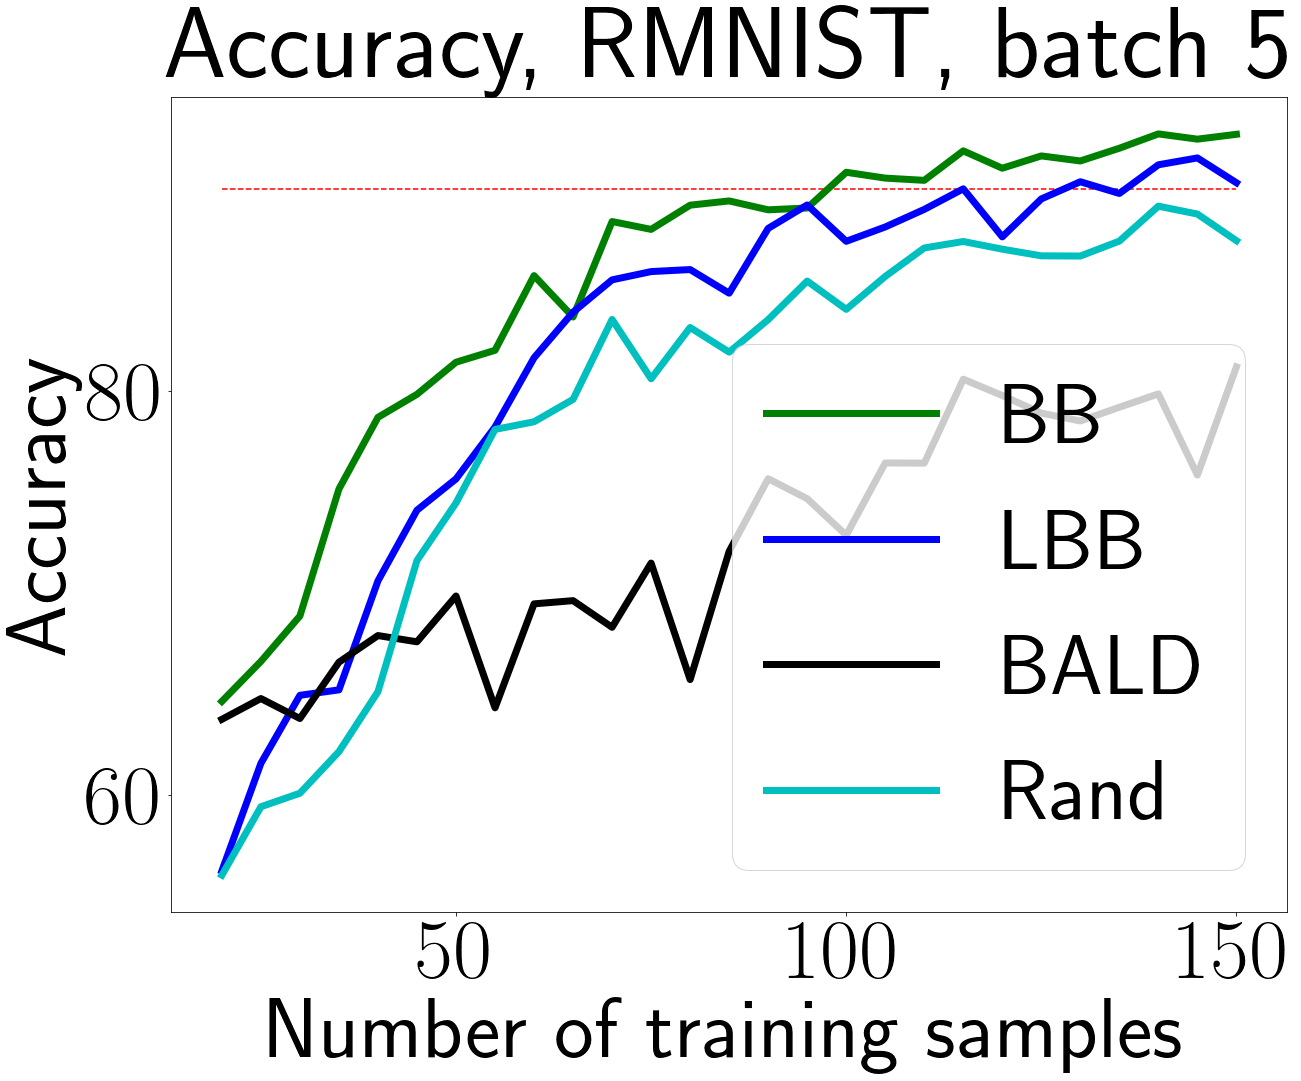

In [29]:
plt.figure(figsize=(20, 15))
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 85

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs4_bb5, 'g', label='BB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), lbb45, 'b', label='LBB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs4_b5, 'k', label='BALD', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), random45, 'c', label='Rand', linewidth=7.0)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy, RMNIST, batch 5")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.legend()
plt.savefig('rmnist-batch5.svg')
plt.show()

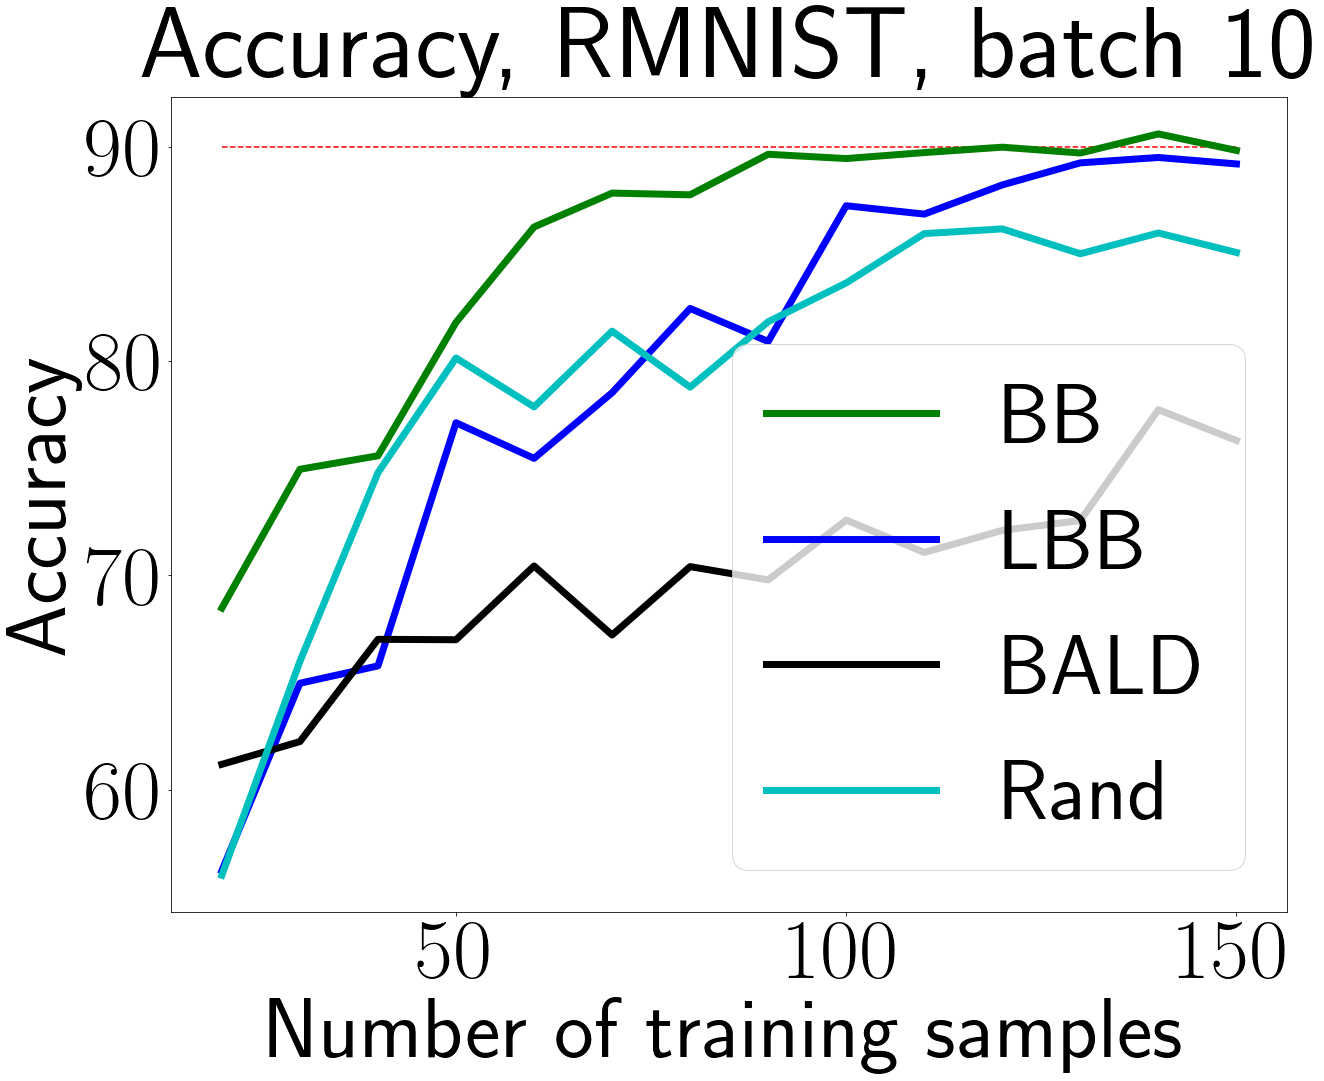

In [30]:
plt.figure(figsize=(20, 15))
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 85

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), test_accs4_bb10, 'g', label='BB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), lbb410, 'b', label='LBB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), test_accs4_b10, 'k', label='BALD', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size*2), random410, 'c', label='Rand', linewidth=7.0)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy, RMNIST, batch 10")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.legend()
plt.savefig('rmnist-batch10.svg')
plt.show()

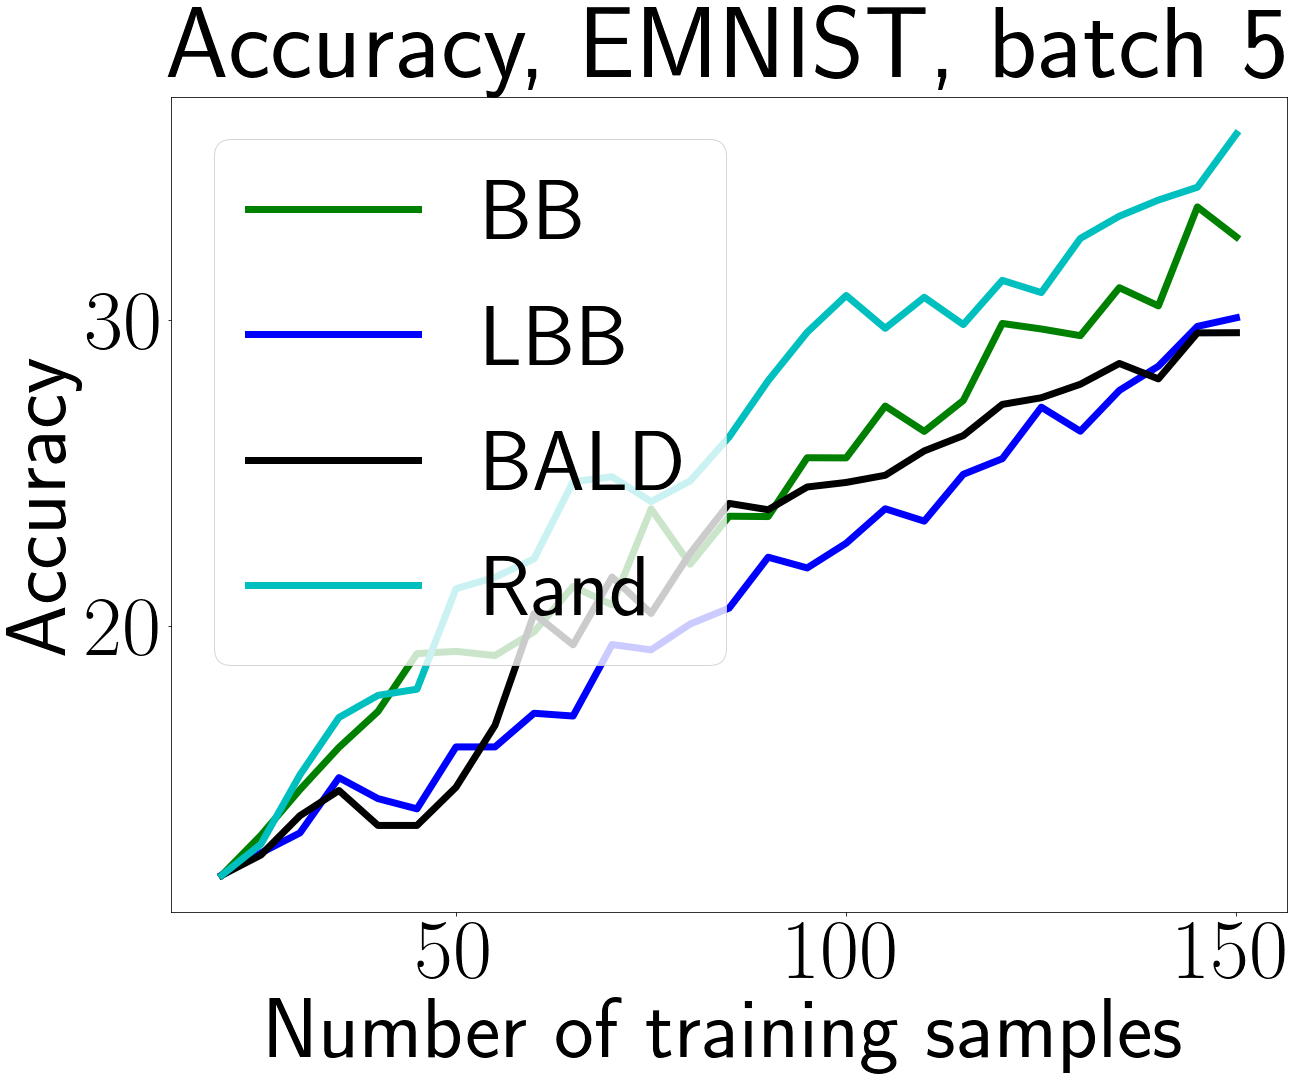

In [35]:
plt.figure(figsize=(20, 15))
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 85

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), bb_emnist, 'g', label='BB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), lbb_emnist, 'b', label='LBB', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), bald_emnist, 'k', label='BALD', linewidth=7.0)
plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), random_emnist, 'c', label='Rand', linewidth=7.0)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy, EMNIST, batch 5")
# plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.legend()
plt.savefig('emnist-batch5.svg')
plt.show()